# 1 Introduction
## *What* is customer churn?
Customer churn is one of the most important business metrics since retention cost of an existing customer is much less than the acquisition cost of new customer. Churn prediction is an important application of big data and machine learning. 

This study will use Sparkfiy music data provided by (udacity.com) to predict customer churn.

In [ ]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as spk_funcs
from pyspark.sql.functions import col, concat, lit, desc, explode, \
        min, max,avg, stddev, split, udf, isnan, count, when,countDistinct,\
        collect_list
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, 
from pyspark.ml.feature import IDF, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import re
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# create a Spark session
spark = SparkSession.builder\
        .master("local")\
        .appName("sparkify")\
        .getOrCreate()

# 2 Load and Clean Dataset 

In [ ]:
raw_df = spark.read.json("mini_sparkify_event_data.json")
raw_df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [ ]:
raw_df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [ ]:
print (raw_df.columns)

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


## 2.1 Check whether the data have duplicated inputs

In [ ]:
raw_df.count(), raw_df.distinct().count()

(286500, 286500)

## 2.2 Count how many null or nan values are in the input

In [ ]:
raw_df.select( [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in raw_df.columns] ).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



## 2.3 When artist is null, song is also null

In [ ]:
print ("Number of record when both artist and song are null:", raw_df.filter(raw_df.artist.isNull() & raw_df.song.isNull()).count())

Number of record when both artist and song are null: 58392


In [ ]:
print ("Number of record when artist are null:", raw_df.filter(raw_df.artist.isNull() ).count())

Number of record when artist are null: 58392


In [ ]:
raw_df.filter(raw_df.artist.isNull() & raw_df.song.isNull()).show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

## 2.4 Check what are the data when firstName, lastName, gender, location, and registration are null

In [ ]:
print ("Number of null or nan records of firstName, lastName, gender, location, and registration :", \
       raw_df.select( [ count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                       for c in ['firstName', 'lastName', 'gender', 'location', 'registration'] ] ).show() )

+---------+--------+------+--------+------------+
|firstName|lastName|gender|location|registration|
+---------+--------+------+--------+------------+
|     8346|    8346|  8346|    8346|        8346|
+---------+--------+------+--------+------------+

Number of null or nan records of firstName, lastName, gender, location, and registration : None


In [ ]:
print ("Number of records when firstName, lastName, gender, location, and registration are null:", \
       raw_df.filter(raw_df.firstName.isNull() & \
                     raw_df.lastName.isNull() & \
                     raw_df.gender.isNull() & \
                     raw_df.location.isNull() & \
                     raw_df.registration .isNull() \
                    ).count())

Number of records when firstName, lastName, gender, location, and registration are null: 8346


In [ ]:
raw_df.filter(raw_df.firstName.isNull() & \
                     raw_df.lastName.isNull() & \
                     raw_df.gender.isNull() & \
                     raw_df.location.isNull() & \
                     raw_df.registration .isNull() \
                    ).show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [ ]:
raw_df.filter(raw_df.firstName.isNull() & \
                     raw_df.lastName.isNull() & \
                     raw_df.gender.isNull() & \
                     raw_df.location.isNull() & \
                     raw_df.registration .isNull() \
                    ).select("auth").groupBy('auth').count().orderBy('count').show()

+----------+-----+
|      auth|count|
+----------+-----+
|     Guest|   97|
|Logged Out| 8249|
+----------+-----+



In [ ]:
raw_df.filter(raw_df.firstName.isNull() & \
                     raw_df.lastName.isNull() & \
                     raw_df.gender.isNull() & \
                     raw_df.location.isNull() & \
                     raw_df.registration.isNull() & \
                     (raw_df.auth=='Guest') \
                    ).show(5)

+------+-----+---------+------+-------------+--------+------+-----+--------+------+--------+------------+---------+----+------+-------------+---------+------+
|artist| auth|firstName|gender|itemInSession|lastName|length|level|location|method|    page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+-----+---------+------+-------------+--------+------+-----+--------+------+--------+------------+---------+----+------+-------------+---------+------+
|  null|Guest|     null|  null|            0|    null|  null| free|    null|   GET|   Error|        null|      151|null|   404|1540841775000|     null|      |
|  null|Guest|     null|  null|            1|    null|  null| free|    null|   GET|    Home|        null|      151|null|   200|1540841817000|     null|      |
|  null|Guest|     null|  null|            2|    null|  null| free|    null|   GET|Register|        null|      151|null|   200|1540841826000|     null|      |
|  null|Guest|     null|  null|            3| 

In [ ]:
raw_df.filter(raw_df.firstName.isNull() & \
                     raw_df.lastName.isNull() & \
                     raw_df.gender.isNull() & \
                     raw_df.location.isNull() & \
                     raw_df.registration .isNull() \
                    ).select("userId").groupBy('userId').count().orderBy('count').show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
+------+-----+



In [ ]:
raw_df.filter(raw_df.userId=="").count()

8346

In [ ]:
raw_df.groupBy('userId').count().orderBy('count', ascending=False).show(3)

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
+------+-----+
only showing top 3 rows



### Comment

It turns out firstName, lastName, gender, location, and registration are null when the session is either guest or log out. Furthermore userId is also empty

So we could drop all the those rows with nulls and empty userId since they are not useful.

In [ ]:
raw_df.groupBy('sessionId').count().orderBy('count').show(10)

+---------+-----+
|sessionId|count|
+---------+-----+
|     1508|    1|
|        7|    1|
|     1460|    1|
|     1374|    1|
|     2263|    1|
|     1760|    1|
|     1527|    1|
|      847|    1|
|     2184|    1|
|     1642|    1|
+---------+-----+
only showing top 10 rows



In [ ]:
# raw_df.select('sessionId').distinct().rdd.map(lambda r:r[0]).collect()
sessionid_uniq = [i.sessionId for i in raw_df.select('sessionId').distinct().collect()]

## 2.5 Drop all record having null value for  firstName, lastName, gender, location, and registration

In [ ]:
print ("raw input records number", raw_df.count())

raw input records number 286500


In [ ]:
cln_df = raw_df.dropna(how='any', subset=['firstName','lastName','gender','location','registration'])
print ("cleaned input records number", cln_df.count())

cleaned input records number 278154


# 3 Feature Engineering

## 3.1 Page and user Id analysis

In [ ]:
cln_df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [ ]:
cln_df.filter('page="Cancellation Confirmation"').select('userId').distinct().count()

52

In [ ]:
cln_df.select('userId').distinct().count(), cln_df.select('registration').distinct().count()

(225, 225)

In [ ]:
cln_df.groupBy(['userId','registration']).count().count()

225

## Comment
Thera are 225 users in this datasets and 52 users are churned. Since This is a fairly small dataset, model performance could be much limited

## 3.2 Define customer churn and encodeing user agent and gender features
    * churn (When customer cancel the subscription)
    * userAgent
    * gender

In [ ]:
# ischurn = udf(lambda x: 2 if x=='Cancellation Confirmation' else (1 if x=='Downgrade' else 0), IntegerType())
ischurn = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
cln_df = cln_df.withColumn('Churn', ischurn(cln_df.page))

In [ ]:
cln_df.select('userAgent').distinct().show(3)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
+--------------------+
only showing top 3 rows



In [ ]:
getGender = udf(lambda x: 0 if x=="F" else (1 if x=="M" else 2), IntegerType())
cln_df = cln_df.withColumn("enc_gender", getGender("gender"))
cln_df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|enc_gender|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|         1|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|

In [ ]:
def getAgent(x):
    if "Macintosh" in x:
        return 1
    elif "Windows" in x:
        return 2
    elif "Linux" in x:
        return 3
    elif "iPhone" in x:
        return 4
    elif "iPad":
        return 5
    else:
        return 0
convertAgent = udf(lambda z: getAgent(z),IntegerType())
cln_df = cln_df.withColumn("System", convertAgent(cln_df.userAgent))
cln_df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|enc_gender|System|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|         1|     2|
|Five Iron Frenzy|Logged In|    Micah|  

## 3.3 Build session DataFrame using counting statistics of artist, song, and session
    * artist
    * sessionId
    * song
    * itemInsession

In [ ]:
count_df = cln_df.groupBy('userId').agg(countDistinct("artist").cast(IntegerType()).alias('num_artist'),\
                             countDistinct('sessionId').cast(IntegerType()).alias('num_session'),\
                             countDistinct('song').cast(IntegerType()).alias('num_song'),\
                            count("itemInsession").cast(IntegerType()).alias("allsession"),\
                                       max("churn").alias("churn"))

In [ ]:
count_df = count_df.withColumn("avgSessionItem", (count_df.allsession/count_df.num_session).cast(IntegerType()))
count_df.show(5)

+------+----------+-----------+--------+----------+-----+--------------+
|userId|num_artist|num_session|num_song|allsession|churn|avgSessionItem|
+------+----------+-----------+--------+----------+-----+--------------+
|100010|       252|          7|     269|       381|    0|            54|
|200002|       339|          6|     378|       474|    0|            79|
|   125|         8|          1|       8|        11|    1|            11|
|    51|      1385|         10|    1854|      2464|    1|           246|
|   124|      2232|         29|    3339|      4825|    0|           166|
+------+----------+-----------+--------+----------+-----+--------------+
only showing top 5 rows



## 3.4 Build page DataFrame by counting page visisted

Since the current work focus to build a working prototype workflow, page counting,ie user activity, was conducted for the entire period for each customersand this certainly has drawbacks. Statistics about weekly, bi-weekly, and maybe monthly user activity would be more userful. 

In [ ]:
page_df = cln_df.groupby(['userId','page']).count().groupby(['userId']).pivot('page').sum().fillna(value=0)
print (page_df.count())
# for col_name in page_df.columns[1:]:
#     page_df = page_df.withColumn(col_name, col(col_name).cast('float'))
page_df.show(5)

225
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    3|         4|              8|     0|                        0|        5|    0|   2|  20|     5|     387|          7|            0|       3|               0|             1|          6|       21|      2|
|100010|    1|         4|              7|     0|                        0|        0|    0|   2|  11|     5|     275|         52|            

## 3.5 Merge gender and system with page counting DataFrame and session DataFrame

In [ ]:
# https://kb.databricks.com/data/join-two-dataframes-duplicated-columns.html
fnlcln_df = count_df.join(page_df, ["userId"], "inner").\
                join(cln_df.select('userId', 'enc_gender', 'System').drop_duplicates(),"userId","inner")
print (fnlcln_df.count())
fnlcln_df.show(3, False)

225
+------+----------+-----------+--------+----------+-----+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+----------+------+
|userId|num_artist|num_session|num_song|allsession|churn|avgSessionItem|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|enc_gender|System|
+------+----------+-----------+--------+----------+-----+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+----------+------+
|100010|252       |7          |269     |381       |0    |54            |1    |4         |7              |0  

## 3.6 Imbalance data weight
Since 52 user out of 225 are churned, classweight is added to handle class imbalance problem as correct churn prediction is very important to improve customer retention.

In [ ]:
BalancingRatio = fnlcln_df.filter('churn==0').count()/fnlcln_df.count()
fnlcln_df = fnlcln_df.withColumn("classWeights", when(fnlcln_df.churn == 1,BalancingRatio).otherwise(1-BalancingRatio))

In [ ]:
fnlcln_pd = fnlcln_df.toPandas()

In [ ]:
fnlcln_pd.head(3)

,userId,num_artist,num_session,num_song,allsession,churn,avgSessionItem,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,enc_gender,System,classWeights
0,100010,252,7,269,381,0,54,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2,0,4,0.231111
1,200002,339,6,378,474,0,79,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2,1,4,0.231111
2,125,8,1,8,11,1,11,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0,1,1,0.768889


## 3.7 categorical and numerical features analysis

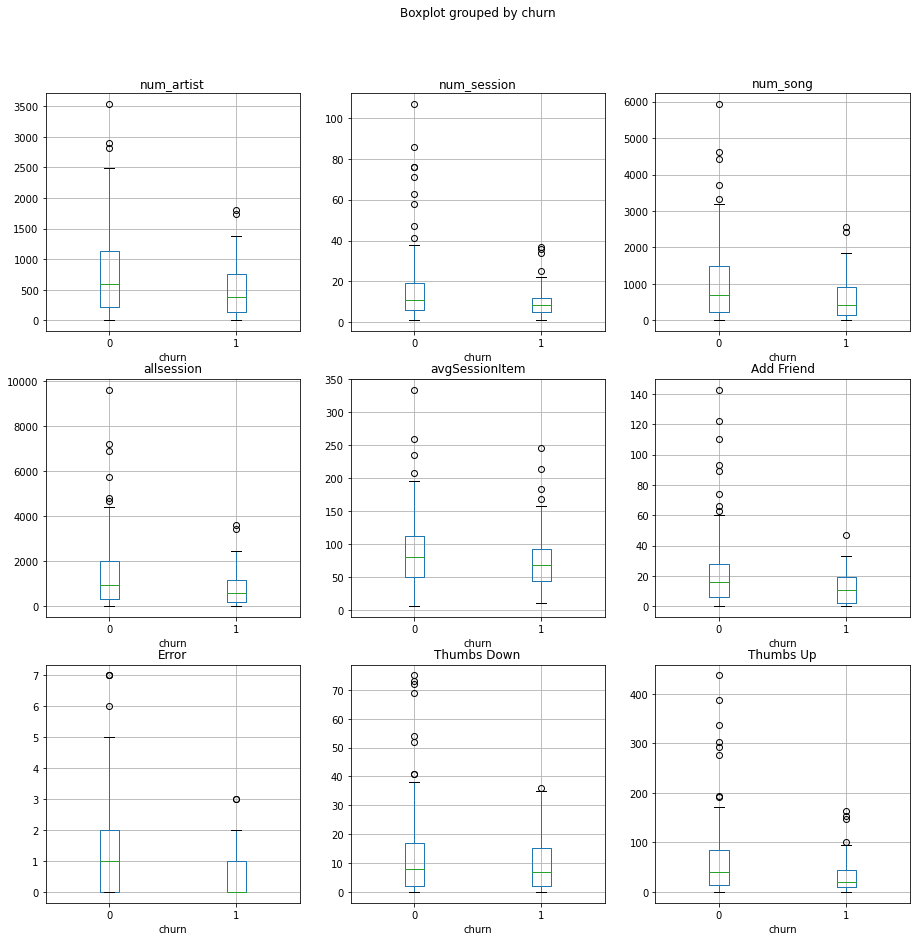

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

plot_features = ['num_artist', 'num_session', 'num_song', 'allsession',\
                 'avgSessionItem','Add Friend','Error','Thumbs Down', 'Thumbs Up']
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
for idx, feature in enumerate(plot_features):
    fnlcln_pd.boxplot(column=feature, by='churn', ax=axs.ravel()[idx])

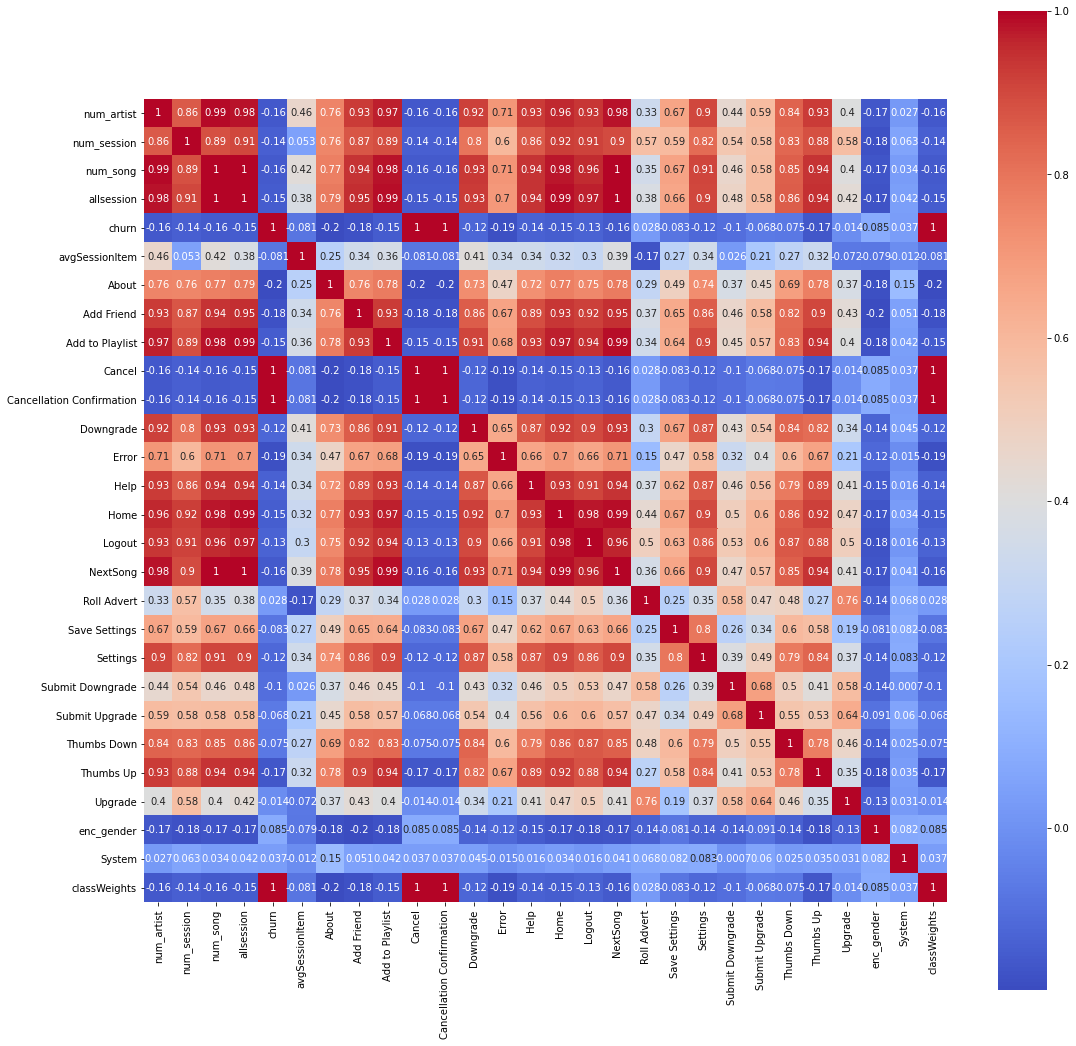

In [ ]:
correlation = fnlcln_pd.fillna(value=0).corr()
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(correlation, ax=ax, annot=True, square=True, cmap='coolwarm');

## Observations
    * It is obvious that subscripted users will listen more songs, log in often, and recommend Sparkify to friends. These features would be very useful to predict customer churn.
    * Cancel and cancellation page visit counts are equivalent to churn and they will not be used in classification model

# 4 Classification Model

* Define numerical and categorical features

In [ ]:
num_features = ['num_artist', 'num_session', 'num_song', 'allsession', \
                'avgSessionItem', 'About', 'Add Friend', 'Add to Playlist', \
                'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', \
                'Roll Advert','Save Settings', 'Settings', 'Submit Downgrade',\
                'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']
cat_features = ['enc_gender', 'System']
print (len(num_features), len(cat_features))

22 2


## 4.1 Build numerical and categorical data processing pipeline

In [ ]:
proc_pipeline = []

# Categorial features
for feature in cat_features:
    stringIndexer = StringIndexer(inputCol=feature, outputCol=feature + "_idx")
    ohe_encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=feature + "_ohe")
    
    proc_pipeline += [stringIndexer] + [ohe_encoder]

    
# Combine categorial features and numerical features and Transform all features into a vector using VectorAssembler
assemblerInputs = [feature + "_idx" for feature in cat_features] + num_features

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
proc_pipeline += [assembler]

scaler = StandardScaler(inputCol = "features",
                        outputCol = "scaledFeatures",
                        withStd = True,
                        withMean = False)
proc_pipeline += [scaler]

partialPipeline = Pipeline().setStages(proc_pipeline)

## 4.2 Use stratified sampling to conduct train and test data split

In [ ]:
# Define train and test data splitting ratio
fractions = fnlcln_df.select("churn").distinct().withColumn("fraction", lit(0.7)).rdd.collectAsMap()

In [ ]:
### Stratified sample data to get training set. set seed for reproducibility
trainingData = fnlcln_df.sampleBy('churn', fractions, seed=1)

In [ ]:
# left_anti join to get test set
trainingDataCloned = spark.createDataFrame(trainingData.rdd, trainingData.schema)
testData = fnlcln_df.join(trainingDataCloned, ["userId"], "left_anti" )

In [ ]:
trainingData.select('churn').groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   37|
|    0|  115|
+-----+-----+



In [ ]:
testData.select('churn').groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   16|
|    0|   57|
+-----+-----+



## 4.3 Using training data to fit the pipeline then transform training and test datasets

In [ ]:
pipelineModel = partialPipeline.fit(trainingData)
train_preppedDataDF = pipelineModel.transform(trainingData)
test_preppedDataDF = pipelineModel.transform(testData)

## 4.4 Model Training

### 4.4.1 Logistic Regression classification

In [ ]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="churn", featuresCol="scaledFeatures",
                        weightCol="classWeights", maxIter=100)

# Train model with Training Data
lrModel = lr.fit(train_preppedDataDF)

In [ ]:
def plot_roc_curve(mdl_fpr_tpr,
                  title = "ROC Curve"):
    
    """
    input: mdl_fpr_tpr
            Dictionary dataset for model tested
            key: model
            value: False Positive Rate and True Positive Rate
    Plot function for ROC curve
    """


    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1], 'b--')
    colors = {"LogisticRegression":"orange",
             "RandomForest":"green",
             "GradientBoostingTree":"red"}
    linestyle = "-."
    for model, (fpr, tpr) in mdl_fpr_tpr.items():
        plt.plot(fpr, tpr, linestyle=linestyle, color=colors[model], label = model)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc='best')
    plt.show()

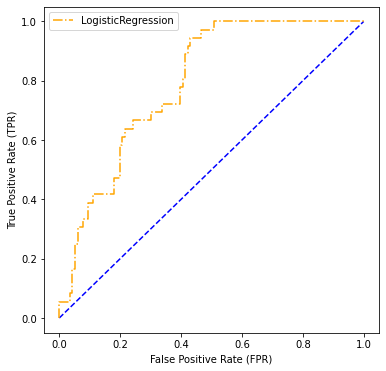

In [ ]:
import collections
fpr = lrModel.summary.roc.select('fpr').collect()
tpr = lrModel.summary.roc.select('tpr').collect()
mdl_fpr_tpr = collections.defaultdict(list)
mdl_fpr_tpr["LogisticRegression"] = [fpr, tpr]
plot_roc_curve(mdl_fpr_tpr)

### 4.4.2 Logistic Regression parameter tuning

* To improve customer churn prediction and handle imbalanced input, metric "areaUnderPR" is used and regularization are further tuned 

In [ ]:
lr = LogisticRegression(labelCol="churn", featuresCol="scaledFeatures",
                        weightCol="classWeights", maxIter=100)

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.5])
             .addGrid(lr.maxIter, [100, 200])
             .build())

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churn', metricName = "areaUnderPR")

# Create 3-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
cvModel = cv.fit(train_preppedDataDF)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

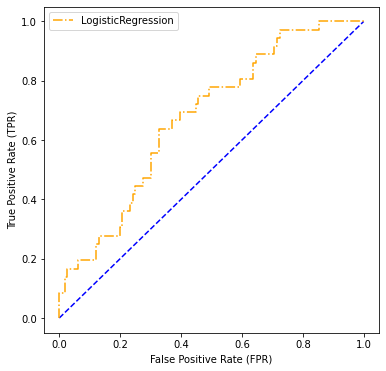

In [ ]:
fpr = cvModel.bestModel.summary.roc.select('fpr').collect()
tpr = cvModel.bestModel.summary.roc.select('tpr').collect()
mdl_fpr_tpr = collections.defaultdict(list)
mdl_fpr_tpr["LogisticRegression"] = [fpr, tpr]
plot_roc_curve(mdl_fpr_tpr)

* Conduct prediction with validation data, ie. test daa

In [ ]:
# Make predictions on test data using the transform() method.
predictions = cvModel.bestModel.transform(test_preppedDataDF)

# View model's predictions and probabilities of each prediction class
selected = predictions.select("churn", "prediction", "probability")

In [ ]:
selected.groupby('churn', 'prediction').count().show()

+-----+----------+-----+
|churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|    5|
|    0|       0.0|   31|
|    1|       1.0|   11|
|    0|       1.0|   26|
+-----+----------+-----+



In [ ]:
y_true = predictions.select("churn")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_names = [0, 1]
cnf_matrix = confusion_matrix(y_true, y_pred, labels= class_names)
cnf_matrix

array([[31, 26],
       [ 5, 11]])

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    input: cm   confusion_matrix

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
#     plt.ylabel('True label',rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

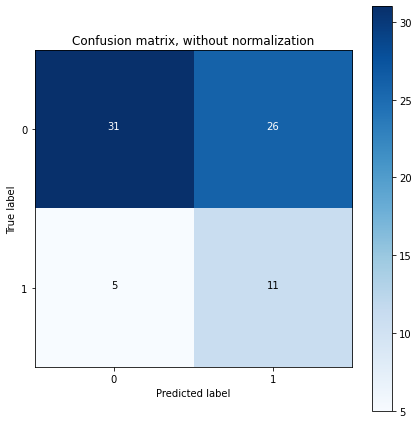

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

### 4.4.3 Random forest 

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaledFeatures",
                            weightCol="classWeights")

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [3, 5])
             .addGrid(rf.numTrees, [3,6, 9])
             .build())

# Create 3-fold CrossValidator
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cv_rf_Model = cv_rf.fit(train_preppedDataDF)

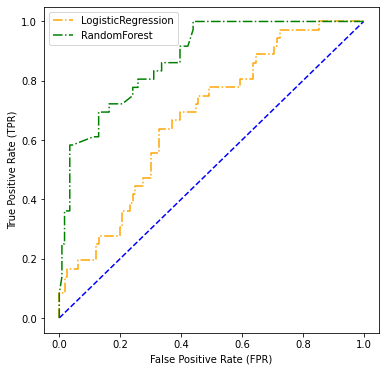

In [ ]:
fpr = cv_rf_Model.bestModel.summary.roc.select('fpr').collect()
tpr = cv_rf_Model.bestModel.summary.roc.select('tpr').collect()
mdl_fpr_tpr["RandomForest"] = [fpr, tpr]
plot_roc_curve(mdl_fpr_tpr)

* Conduct prediction with validation data, ie. test daa

In [ ]:
predictions = cv_rf_Model.bestModel.transform(test_preppedDataDF)

y_true = predictions.select("churn")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_names = [0, 1]
cnf_matrix = confusion_matrix(y_true, y_pred, labels= class_names)
cnf_matrix

array([[43, 14],
       [10,  6]])

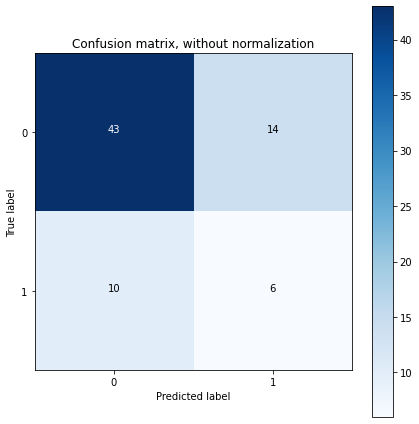

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

* Comment
Random forest tree is a more powerful model, though it is prone to overfitting when using very limited amount of data.

# 5 Conclusion

Spark machine learning model was built and trained with mini Sparkify input data. This model conducted feature engineering, feature processing pipeline, and classification model training. A prototype flow was established for further improvement.

* Statistics of weekly, bi-weekly, and maybe monthly user activities might be more powerful features to predict customer churn. This would be the future work.
* Due to limited resource and budget, the mini Sparkify dataset was used in this study. The full 12 GB data would be used when situation allowed.
